# Commodity Price Prediction Model

This notebook is used to carry out the ETL, EDA and Model experiments of the data downloaded from Alpha-Advantage API. The steps would be:

    1. Create a pipeline to download the dataset using the API
    2. Carry out and preliminary EDA on the data to determining the initial cleaning requirements.
    3. Add the cleaning steps to the pipeline.
    4. Carry out a full EDA on the data to determine additional transformations required and modelling technique(s) to explore.
    5. Split the data 
    6. Create the model(s) and evaluate accordingly to select the best model(s)
    7. Save best model to utilise in the web app.

In [113]:
# Import the required libraries for ETL and EDA

# Data wrangling and visusalisation libraries
import plotly.express as px
from datetime import datetime
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Environment variables and file management libraries
from dotenv import load_dotenv
import os

# API Library
from alpha_vantage.commodities import Commodities

# Statistical libraries
from statsmodels.graphics.tsaplots import month_plot, quarter_plot
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


# Model Evaluation libraries
from sklearn.metrics import mean_squared_error, root_mean_squared_error

# Time Series Models
from statsmodels.tsa.arima.model import ARIMA
from arch import arch_model



In [2]:
# Initialise the environment variable  and load the API_Key
load_dotenv(override=True)

# Load the API_KEY
api_key = os.getenv('api_key')

`We will create a pipeline that will extract, clean and save the data programmatically from the API. This would be built step by step below by adding components as the EDA is being done. The ETL code would be transfered to a Python Script.`

In [ ]:
# Create a data extraction Pipeline. This will be updated as the 
class CommodityData:
    """"
    This class objects defines the data extraction, transformation, cleaning and loading stage of the application"""

    def __init__(self, api_key=config.api_key):
        """ Initiates the class object with the api_key.
        Sets the base directory      
        
        """
        self.api_key=api_key
        self.cd = Commodities(self.api_key)

        base_dir = os.path.abspath(os.path.dirname(__file__))
        self.data_dir = os.path.join(base_dir, 'data')


    def etl_commodity_data(self, commodity, interval, start_date , end_date):
        """" Extract data from alpha-vantage APi and save into csv if not already downloaded
        
        Parameters:
        commodity: The alpha-vantage commodity code 
        interval: Interval for the data - options ['daily', 'monthly', 'yearly']
        start_date: Start date for data in format YYYY-MM-DD 
        end_date: End date for data in format YYYY-MM-DD   
        """    

        # Convert string dates to datetime objects 
        start_date = datetime.strptime(start_date, '%Y-%m-%d') 
        end_date = datetime.strptime(end_date, '%Y-%m-%d')
        # today_date = datetime.strptime(str(datetime.now().strftime('%Y-%m-%d')), '%Y-%m-%d')
        
        # from IPython import get_ipython # Get the current working directory 
        # base_dir = get_ipython().run_line_magic('pwd', '')
        # Get list of files in data directory
        if commodity == 'WTI':
            wti_dir = os.path.join(self.data_dir, 'WTI')
            # Check if the directory exists and create it if it does not 
            if not os.path.exists(wti_dir): 
                os.makedirs(wti_dir)
            file = os.listdir(wti_dir)
            
            # Check if there is no existing download
            if str(end_date.strftime('%Y-%m-%d') +'.csv') not in file:
                # Download from API for commodity requested
                wti_data = self.cd.get_wti(interval)
                
                if wti_data[0].values.any() != "":
                    wti_df = pd.DataFrame(wti_data[0])
                    
                    # Transform to time-series df
                    wti_df.set_index('date', drop=True, inplace=True)
                    
                    # Convert date column to datetime
                    wti_df.index = pd.to_datetime(wti_df.index)

                    # Replace the . with nan
                    wti_df['value'] = wti_df['value'].replace('.', np.nan)                         
                        
                    # Fill missing data using backfill
                    wti_df = wti_df.bfill()

                    # Remove negative and zero values
                    wti_df = wti_df[wti_df['value'] >= 0]

                    # Load the full file to csv 
                    wti_df.to_csv(f'data/{commodity}/{str(end_date.strftime('%Y-%m-%d') +'.csv')}')

                    # Filter for the start date and end date
                    wti_df = wti_df[(wti_df.index >= start_date) & (wti_df.index <= end_date)]
                else:
                    data = pd.DataFrame() # Create an empty DataFrame if data is unavailable or response fails return
                    
                    return print("No data available - try again later")
            
                return wti_df    
                    
            else:
                wti_df = pd.read_csv(f'data/{commodity}/{str(end_date.strftime('%Y-%m-%d') +'.csv')}')
                
                # Transform to time-series df
                wti_df.set_index('date', drop=True, inplace=True)
                
                # Convert date column to datetime
                wti_df.index = pd.to_datetime(wti_df.index)
                                           
                # Replace the . with nan
                wti_df['value'] = wti_df['value'].replace('.', np.nan)        
                # Fill missing data using backfill
                wti_df = wti_df.bfill()

                # Remove negative and zero values
                wti_df = wti_df[wti_df['value'] >= 0]
                
                # Filter for the start date and end date
                wti_df = wti_df[(wti_df.index >= start_date) & (wti_df.index <= end_date)]
            return wti_df
        
        if commodity == 'brent':
            brent_dir = os.path.join(self.data_dir, 'brent')
            # Check if the directory exists and create it if it does not 
            if not os.path.exists(brent_dir): 
                os.makedirs(brent_dir)
            file = os.listdir(brent_dir)
            
            # Check if there is no existing download
            if str(end_date.strftime('%Y-%m-%d') +'.csv') not in file:
                # Download from API for commodity requested
                brent_data = self.cd.get_brent(interval)
                
                if brent_data[0].values.any() != "":
                    brent_df = pd.DataFrame(brent_data[0])
                    
                    # Transform to time-series df
                    brent_df.set_index('date', drop=True, inplace=True)
                    
                    # Convert date column to datetime
                    brent_df.index = pd.to_datetime(brent_df.index)

                    # Replace the . with nan
                    brent_df['value'] = brent_df['value'].replace('.', np.nan)                         
                        
                    # Fill missing data using backfill
                    brent_df = brent_df.bfill()

                    # Remove negative and zero values
                    brent_df = brent_df[brent_df['value'] >= 0]

                    # Load the full file to csv 
                    brent_df.to_csv(f'data/{commodity}/{str(end_date.strftime('%Y-%m-%d') +'.csv')}')

                    # Filter for the start date and end date
                    brent_df = brent_df[(brent_df.index >= start_date) & (brent_df.index <= end_date)]
                else:
                    data = pd.DataFrame() # Create an empty DataFrame if data is unavailable or response fails return
                    
                    return print("No data available - try again later")
            
                return brent_df    
                    
            else:
                brent_df = pd.read_csv(f'data/{commodity}/{str(end_date.strftime('%Y-%m-%d') +'.csv')}')
                
                # Transform to time-series df
                brent_df.set_index('date', drop=True, inplace=True)
              
                # Convert date column to datetime
                brent_df.index = pd.to_datetime(brent_df.index)
                                           
                # Replace the . with nan
                brent_df['value'] = brent_df['value'].replace('.', np.nan)        
                # Fill missing data using backfill
                brent_df = brent_df.bfill()
                # Filter for the start date and end date
                brent_df = brent_df[(brent_df.index >= start_date) & (brent_df.index <= end_date)]
            return brent_df
        


NameError: name 'config' is not defined

In [3]:
# Instantiate the alpha_vantage API object
cd = Commodities(api_key)

# CRUDE OIL (WTI)

In [4]:
# Set variables for different scenarios
commodities = ['WTI', 'brent']
interval = ['daily', 'weekly', 'monthly']


In [5]:
# Download data from API
wti_data = cd.get_wti(interval[0])

In [6]:
# Explore the type of data downloaded
type(wti_data)

tuple

In [7]:
# Explore the content of the `tuple``
wti_data

(             date  value
 0      2025-01-13  79.57
 1      2025-01-10  77.27
 2      2025-01-09      .
 3      2025-01-08  73.99
 4      2025-01-07  74.99
 ...           ...    ...
 10178  1986-01-08  25.87
 10179  1986-01-07  25.85
 10180  1986-01-06  26.53
 10181  1986-01-03  26.00
 10182  1986-01-02  25.56
 
 [10183 rows x 2 columns],
 None)

In [8]:
# Extract the DataFrame from the tuple
df = wti_data[0]

In [9]:
# Confirm the object extracted is a DataFrame
type(df)

pandas.core.frame.DataFrame

In [10]:
# Explore the top of the dataset
df.head()

,date,value
0,2025-01-13,79.57
1,2025-01-10,77.27
2,2025-01-09,.
3,2025-01-08,73.99
4,2025-01-07,74.99


In [11]:
# Explore the tail of dataset
df.tail()

,date,value
10178,1986-01-08,25.87
10179,1986-01-07,25.85
10180,1986-01-06,26.53
10181,1986-01-03,26.00
10182,1986-01-02,25.56


In [12]:
# Explore the general info of the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10183 entries, 0 to 10182
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    10183 non-null  object
 1   value   10183 non-null  object
dtypes: object(2)
memory usage: 159.2+ KB


In [13]:
# Check for missing values
df.isna().sum()

date     0
value    0
dtype: int64

<Axes: >

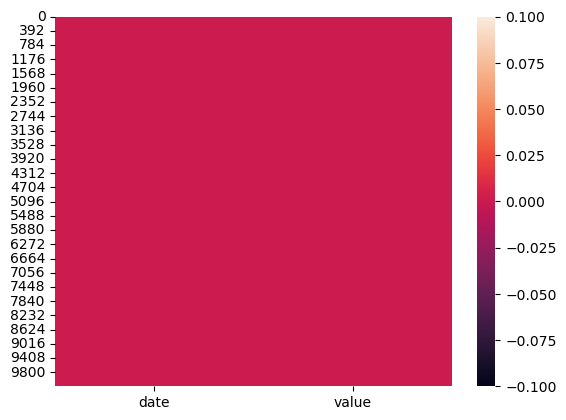

In [14]:
# Visualise for missing data
sns.heatmap(df.isnull())


We can see the following issues with the data quality with exploration done so far:

1. `date` and `value` columns have the `object` data type instead of `datetime` and `float` respectively.
2. The value has `.` as values thus not relecting as missing values

In [15]:
# Explore the instances of . as values further
len(df[df['value'] == '.'])

355

We will address these issues by:

1. Convert `date` column to datetime
2. Replace `.` values with `nan`
3. Impute missing values with backfill
4. Convert value data type to float

In [16]:
import numpy as np
# Convert date column to datetime
df['date'] = pd.to_datetime(df['date'])

# Replace . with nan
df['value'] = df['value'].replace('.', np.nan)

# Impute missing values with NaN
df.bfill(inplace=True)

# Convert value column to float
df['value'] = df['value'].astype('float')

# Confirm transformation and missing values
df.info(), df.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10183 entries, 0 to 10182
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    10183 non-null  datetime64[ns]
 1   value   10183 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 159.2 KB


(None,
 date     0
 value    0
 dtype: int64)

In [17]:
# Explore the descriptive statistic summary
df.describe()

,date,value
count,10183,10183.000000
mean,2005-07-08 19:11:56.606108288,47.689382
min,1986-01-02 00:00:00,-36.980000
25%,1995-10-05 12:00:00,20.215000
50%,2005-07-08 00:00:00,40.570000
75%,2015-04-11 12:00:00,71.405000
max,2025-01-13 00:00:00,145.310000
std,NaN,29.637192


There is a negative value which is not expected for commodity prices. This should be explored further. Let's see the distribution of prices.

<Figure size 800x500 with 0 Axes>

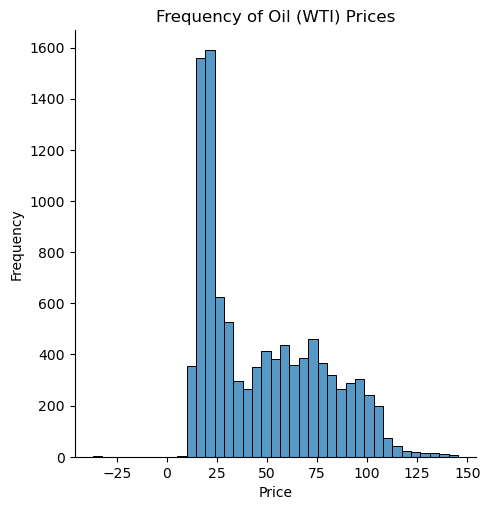

In [27]:
plt.figure(figsize=(8,5))
sns.displot(data=df, x='value')
plt.title('Frequency of Oil (WTI) Prices')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

The data is skewed to the right with a negative value which needs to be cleaned. There instances of high crude oil prices ($120) but this is not very comongcommon

In [28]:
# Check for negative or zero values 
df[df['value'] <= 0]

,date,value
1235,2020-04-20,-36.98


In [29]:
# Drop the negative value
df = df[df['value'] >= 0]

In [30]:
# Confirm the removal of negative or zero values 
df[df['value'] <= 0]

,date,value


Text(0, 0.5, 'Price')

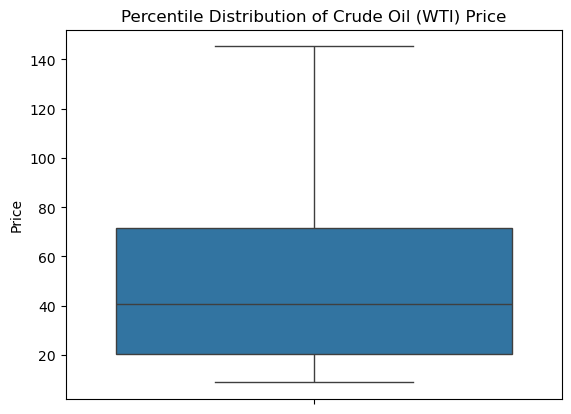

In [34]:
# Explore updated version of dataset with a boxplot
sns.boxplot(df['value'])
plt.title('Percentile Distribution of Crude Oil (WTI) Price')
plt.ylabel('Price')

In [35]:
# Convert the DataFrame to a timeseries
df.set_index('date', drop=True, inplace=True)


In [36]:
# Confirm we now have a time series dataset
df

,value
date,
2025-01-13,79.57
2025-01-10,77.27
2025-01-09,73.99
2025-01-08,73.99
2025-01-07,74.99
...,...
1986-01-08,25.87
1986-01-07,25.85
1986-01-06,26.53


### EDA of Time Series Datasetm

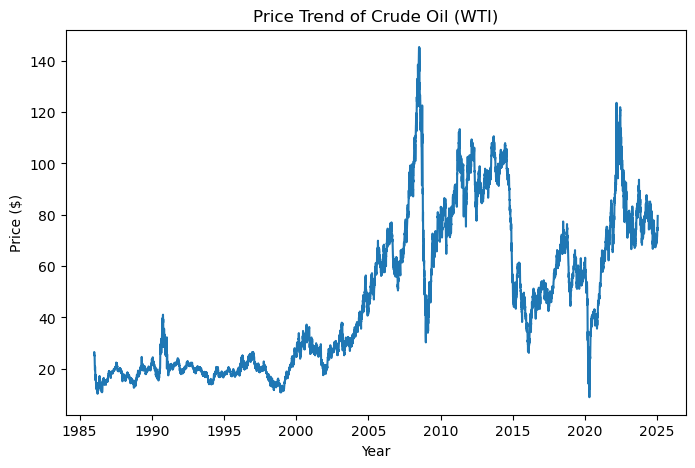

In [38]:
# Visualise the time series with a line plot
plt.figure(figsize=(8,5))
plt.plot(df)

plt.xlabel('Year')
plt.ylabel('Price ($)')
plt.title('Price Trend of Crude Oil (WTI)');


The price was mostly with low volatilty until year 2000 from where the upward trend starts to become noticable. We can reduce our horizon from year 2000 - 2025. We will also add a monthly rolling average to smoothen the plot.

In [55]:
df1 = df[df.index >= '2000']

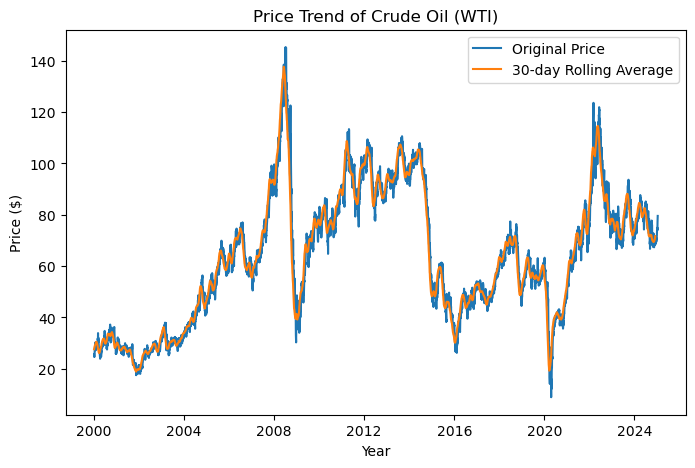

In [61]:
# Visualise the time series with a line plot from year 2000 with 
plt.figure(figsize=(8,5))
plt.plot(df1, label='Original Price')
plt.plot(df1.rolling(window=30).mean(), label='30-day Rolling Average')

plt.xlabel('Year')
plt.ylabel('Price ($)')
plt.title('Price Trend of Crude Oil (WTI)')
plt.legend();

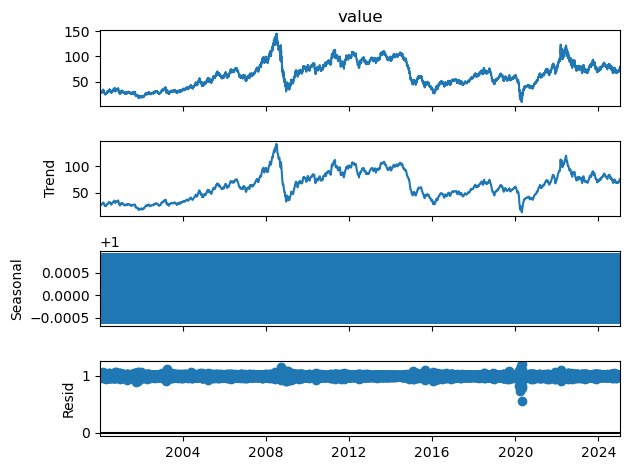

In [108]:

df1 = df1.sort_index()


result = seasonal_decompose(df1['value'] , model='multiplicative', period=7)
result.plot()
plt.show()

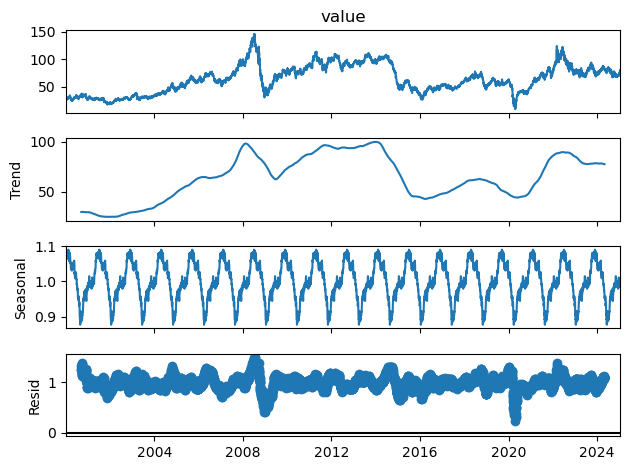

In [109]:

df1 = df1.sort_index()


result = seasonal_decompose(df1['value'] , model='multiplicative', period=365)
result.plot()
plt.show()


Original Data (value): This subplot shows the raw time series data over a period from around 2000 to 2025. There are clear fluctuations in the data with noticeable peaks and troughs, indicating variation over time.

Trend Component (Trend): This subplot isolates the underlying trend in the data. The trend component smooths out the short-term variations and highlights the long-term movement. From the plot, it looks like the trend follows a general upward trajectory over time with noticable sharp falls and gradual rise again.

Seasonal Component (Seasonal): This subplot shows the seasonal variations in the data, which are repetitive patterns that occur at regular intervals. Interestingly, in this case, the seasonal component appears to be a flat line at zero. This suggests that there are no significant seasonal patterns present in the data.

Residuals (Resid): This subplot depicts the residuals, which represent the noise or random fluctuations remaining after removing the trend and seasonal components. The residuals seem to be scattered around zero, indicating that the noise is more or less evenly distributed over time expect for the noticable time of peaks.

To summarize, the original data shows significant variation over time, with an upward trend. There are no notable seasonal patterns, and the residuals suggest that random noise is evenly spread throughout the data

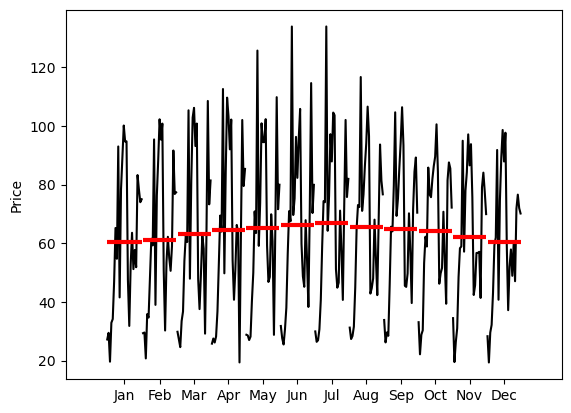

In [75]:
# let's us plot the montly and quarterly seasonality to confirm non-seasonality of the data
month_plot(df1['value'].resample('ME').mean(), ylabel='Price')
plt.show();

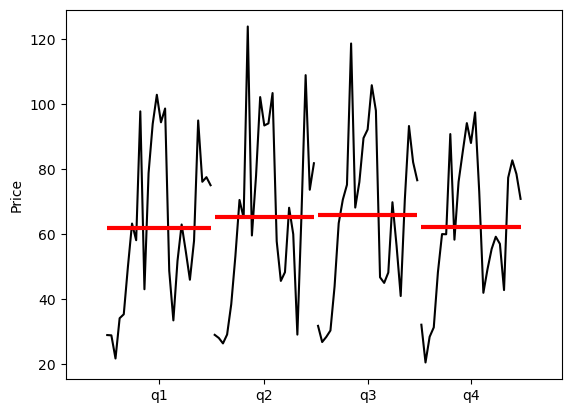

In [78]:
# let's us plot the montly and quarterly seasonality to confirm non-seasonality of the data
quarter_plot(df1['value'].resample('QE').mean(), ylabel='Price')
plt.show();

In [84]:
# Check the dataset for stationality.
# From the plots, the data is not stationary visually. We will check with ADF 
def check_stationality(series):

    result = adfuller(series)
    if result[0] < result[4]['1%']:
        print("The time series is stationary")
    elif result[1] > 0.05:
        print("The time series is not stationary")

    print('ADF Statistics:', result[0])
    print('p-value:', result[1])
    print('Critical Values:', result[4])

In [85]:
check_stationality(df1)

The time series is not stationary
ADF Statistics: -2.624315275136576
p-value: 0.08807520221847803
Critical Values: {'1%': np.float64(-3.431355824531222), '5%': np.float64(-2.8619844883042034), '10%': np.float64(-2.5670065977687684)}


`This suggest a non-stationary time series. We will investigate further with ACF and PACF`

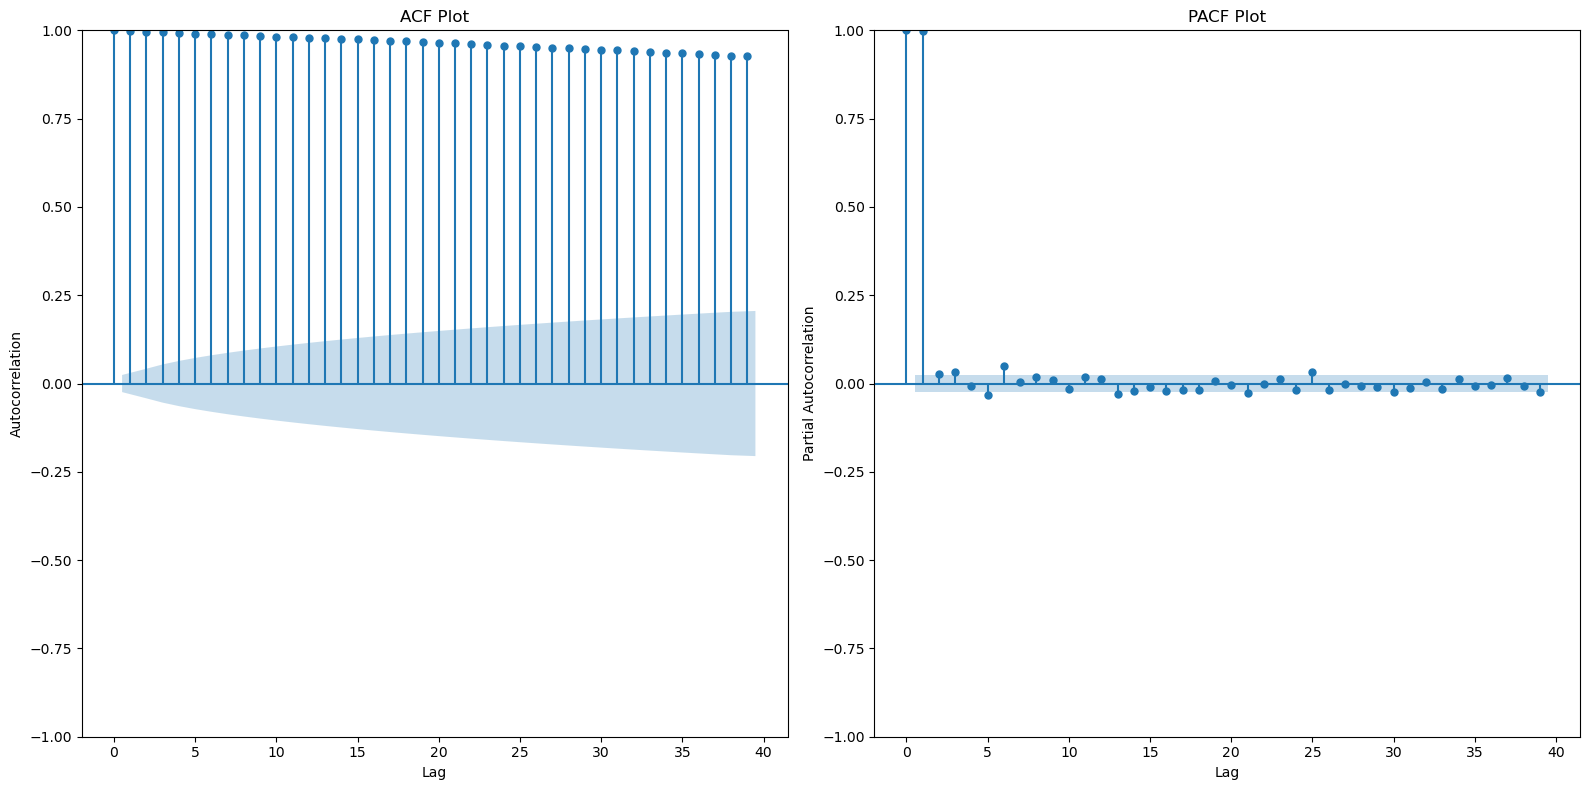

In [87]:
# Plot the acf 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# Create figure and axes 
fig, ax = plt.subplots(1, 2, figsize=(16, 8)) 
# Plot ACF 
plot_acf(df1['value'], ax=ax[0]) 
ax[0].set_xlabel('Lag') 
ax[0].set_ylabel('Autocorrelation') 
ax[0].set_title('ACF Plot') 

# Plot PACF 
plot_pacf(df1['value'], ax=ax[1]) 
ax[1].set_xlabel('Lag') 
ax[1].set_ylabel('Partial Autocorrelation') 
ax[1].set_title('PACF Plot') 

# Show plots 
plt.tight_layout() 
plt.show()


The ACF showing slow decay suggests a correlation with longer lags which is sign of non-stationarity - this can be attributed to the strong trend as there is no seasonality in the data. Also the PACF show correlation drop off at lag=1. We will do the differencing (returns) to take care of this non-stationarity and plot ACF and PACF again

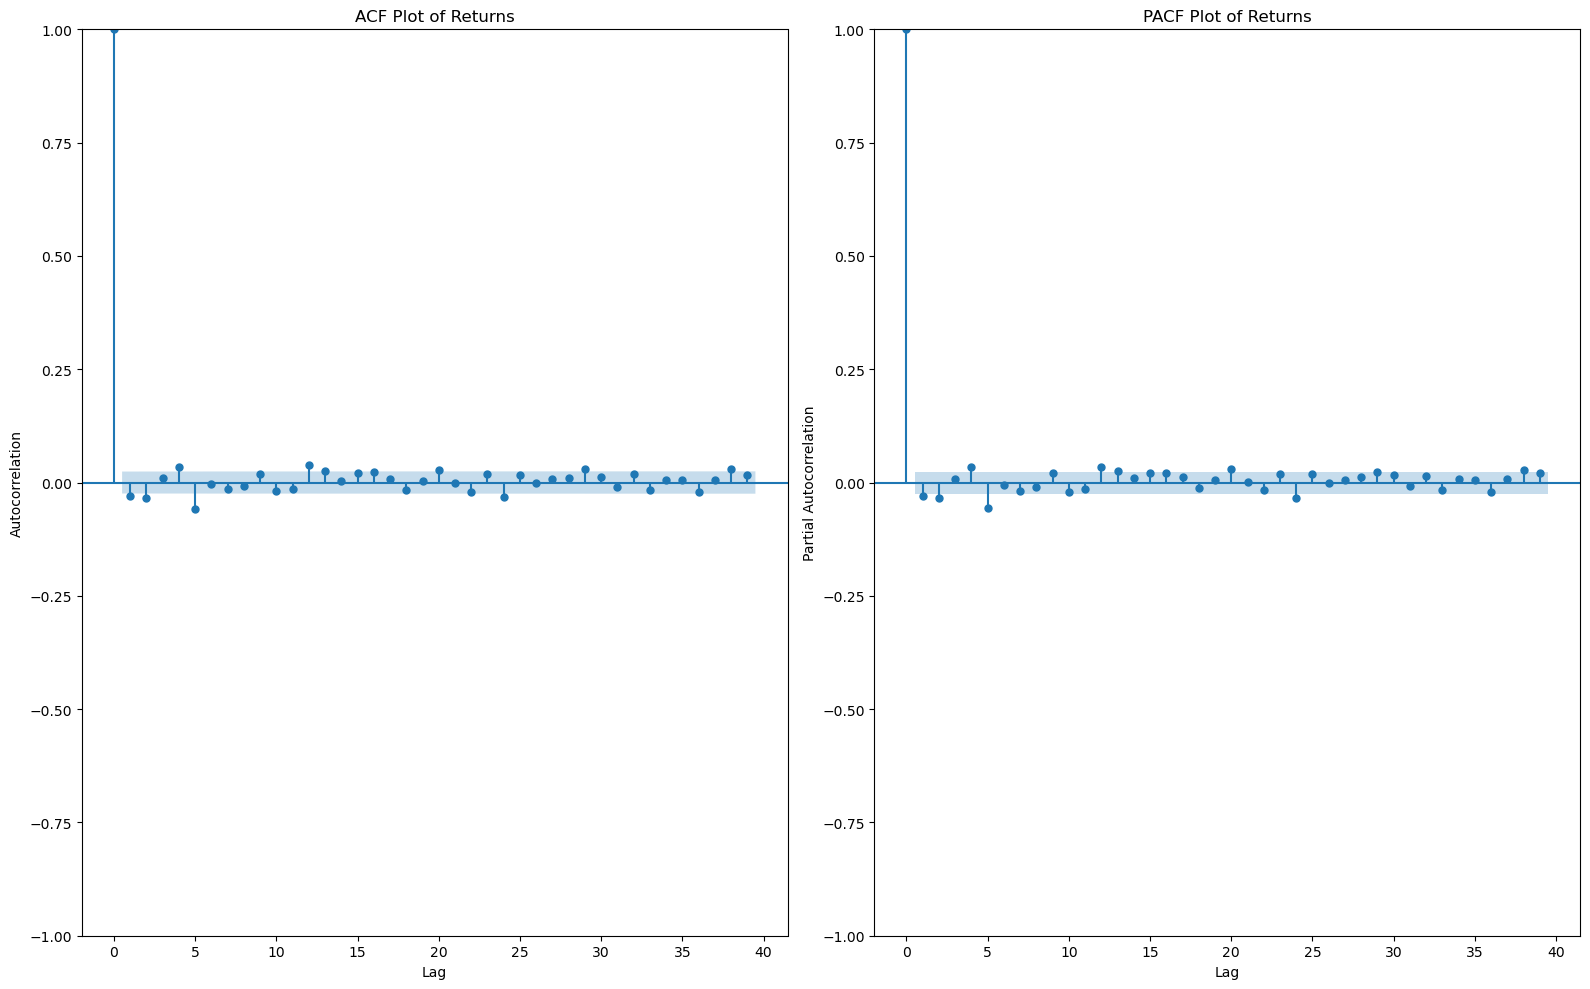

In [90]:
df1['diff'] = df1['value'].diff().dropna() 

fig, ax = plt.subplots(1, 2, figsize=(16, 10)) 

plot_acf(df1['diff'].dropna(), ax=ax[0]) 
ax[0].set_xlabel('Lag') 
ax[0].set_ylabel('Autocorrelation') 
ax[0].set_title('ACF Plot of Returns') 

plot_pacf(df1['diff'].dropna(), ax=ax[1]) 

ax[1].set_xlabel('Lag') 
ax[1].set_ylabel('Partial Autocorrelation') 
ax[1].set_title('PACF Plot of Returns') 

plt.tight_layout() 

plt.show()

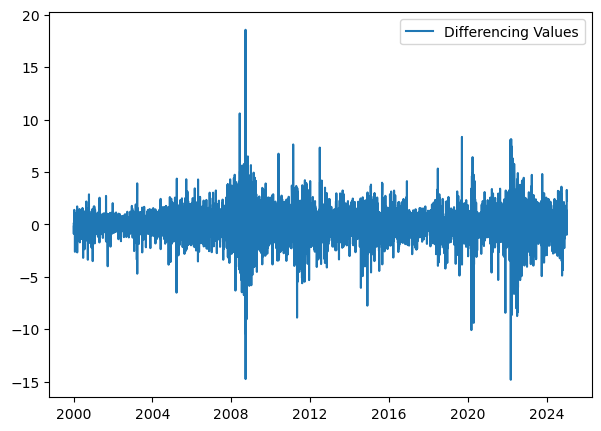

In [92]:
# Visualise the differencing to check if now stationary
plt.figure(figsize=(7,5))
plt.plot(df1['diff'], label='Differencing Values')
plt.legend()
plt.show;

The time series differencing is stationary with notable spikes and dip that would be from external shokes that affected oil prices.

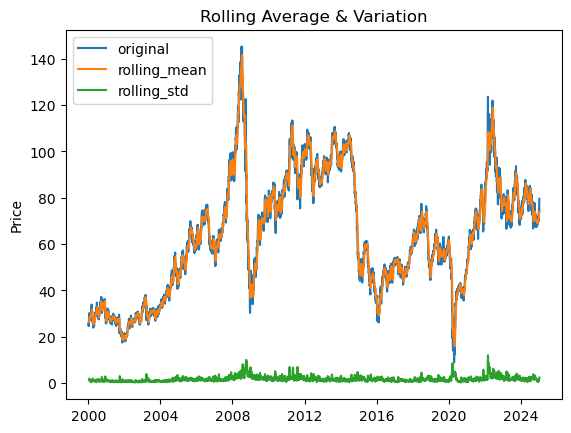

In [95]:
# Use rolling mean and std to further inspect for trends and seasonality
rolling_mean = df1['value'].rolling(window=12).mean()
rolling_std = df1['value'].rolling(window=12).std()
plt.plot(df1['value'], label='original')
plt.plot(rolling_mean, label='rolling_mean')
plt.plot(rolling_std, label='rolling_std')
plt.title("Rolling Average & Variation")
plt.ylabel('Price')
plt.legend()
plt.show;

Based on the observed trends in the original data and the rolling mean, we can conclude that the time series is non-stationary in line with previous analysis as well. A stationary time series should have a constant mean and variance over time, which is not the case here. We have a non-constant mean showing a upward trend , but the constant variation eliminates seasonality as visually seen from the data. There is no seasonal fluactuation in the price of crude oil (WTI). Spikes seen in 2008 and 2020 are easily explained from the global financial crisis of 2008 and Covid-19 in 2020.

# Modelling

### ARIMA Model

Based on the returns ACF & PACF, we would select an ARIMA model starting with (4, 1, 2). We will later carry out hyperparameter tuning for parameters (p, q, d) accordingly based on evaluations

In [ ]:


# Fit ARIMA model on the data
model = ARIMA(df1['value'], order=(4, 1, 2))
model_fit = model.fit()

# Print model summary
print(model_fit.summary())


d:\OneDrive\Documents\Personal Project Portfolio\Financial_Analysis Web App_ Plotly Dash\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\OneDrive\Documents\Personal Project Portfolio\Financial_Analysis Web App_ Plotly Dash\venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\OneDrive\Documents\Personal Project Portfolio\Financial_Analysis Web App_ Plotly Dash\venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                 6530
Model:                 ARIMA(4, 1, 2)   Log Likelihood              -11977.512
Date:                Fri, 17 Jan 2025   AIC                          23969.025
Time:                        20:49:44   BIC                          24016.513
Sample:                             0   HQIC                         23985.446
                               - 6530                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.1596      0.058    -19.970      0.000      -1.273      -1.046
ar.L2         -0.8020      0.063    -12.772      0.000      -0.925      -0.679
ar.L3         -0.0551      0.011     -4.800      0.0

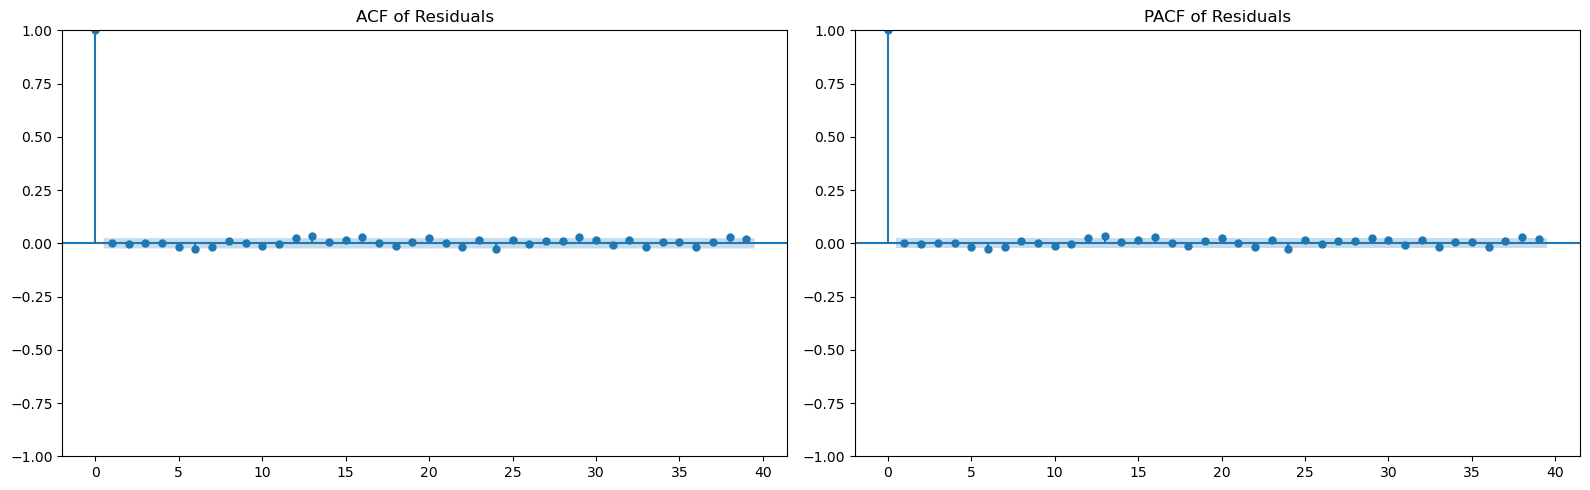

In [97]:
# Plot ACF and PACF of residuals
residuals = model_fit.resid

fig, ax = plt.subplots(1, 2, figsize=(16, 5))

plot_acf(residuals, ax=ax[0])
ax[0].set_title('ACF of Residuals')

plot_pacf(residuals, ax=ax[1])
ax[1].set_title('PACF of Residuals')

plt.tight_layout()
plt.show()


This shows the model is fitting well with no autocorrelation in the residuals. We will Remove the 4th AR since it is not significant from the result and try ARIMA(3,1,2). After we will perform out-of-sample forecast to evaluate the model

In [98]:
# Fit ARIMA model on the  data
model = ARIMA(df1['value'], order=(3, 1, 2))
model_fit = model.fit()

# Print model summary
print(model_fit.summary())

d:\OneDrive\Documents\Personal Project Portfolio\Financial_Analysis Web App_ Plotly Dash\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                 6530
Model:                 ARIMA(3, 1, 2)   Log Likelihood              -11977.772
Date:                Fri, 17 Jan 2025   AIC                          23967.543
Time:                        21:14:21   BIC                          24008.247
Sample:                             0   HQIC                         23981.619
                               - 6530                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.2012      0.043    -28.118      0.000      -1.285      -1.117
ar.L2         -0.8651      0.043    -20.174      0.000      -0.949      -0.781
ar.L3         -0.0674      0.007     -9.779      0.0

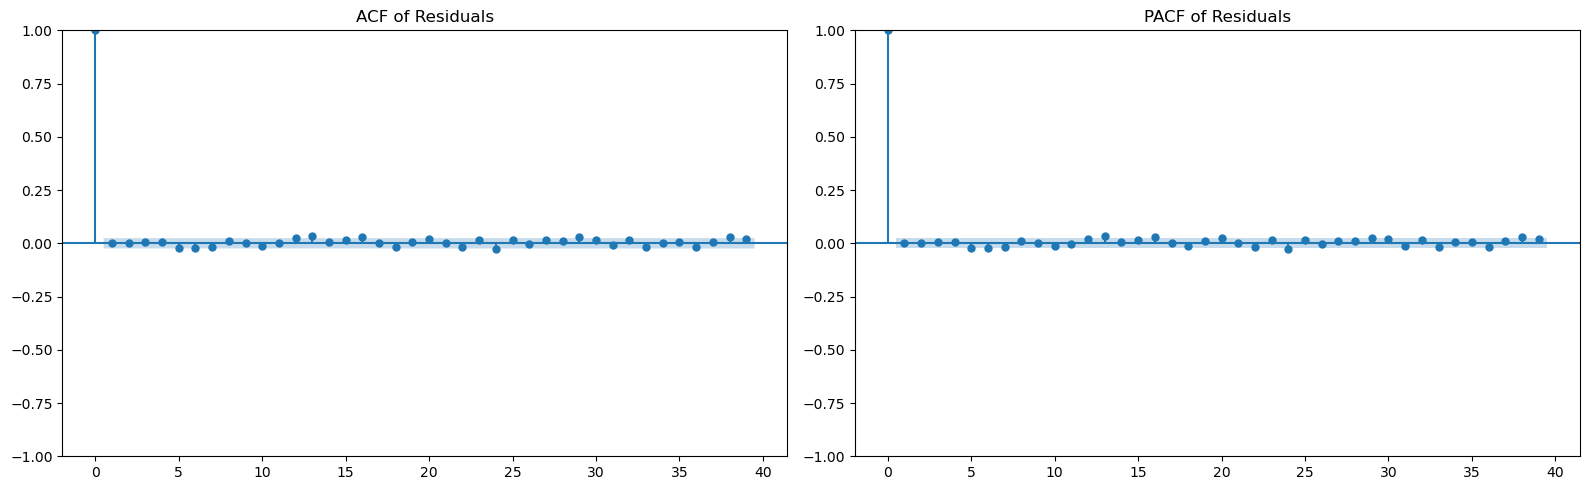

In [99]:
# Plot ACF and PACF of residuals
residuals = model_fit.resid

fig, ax = plt.subplots(1, 2, figsize=(16, 5))

plot_acf(residuals, ax=ax[0])
ax[0].set_title('ACF of Residuals')

plot_pacf(residuals, ax=ax[1])
ax[1].set_title('PACF of Residuals')

plt.tight_layout()
plt.show()

The model has good p-valus for AR & MA however, the residual skewness and Heteroskedasticity will need to be handled. The external shocks to oil price are likely to be the culpriit here.

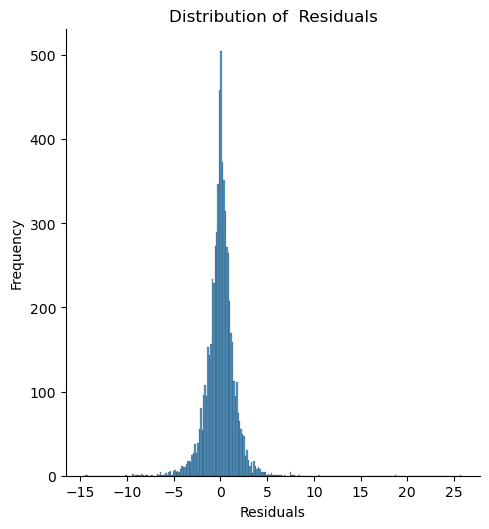

In [104]:
# Plot the distribution of the residuals
sns.displot(residuals)
plt.title('Distribution of  Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency');

In [171]:
# Split the data into training and test datasets
train_size = int(len(df1) * 0.8)

train_df = df1.iloc[:train_size]
test_df = df1.iloc[train_size:]



In [106]:
train_df

,value,diff
date,,
2000-01-03,25.76,NaN
2000-01-04,25.56,-0.20
2000-01-05,24.65,-0.91
2000-01-06,24.79,0.14
2000-01-07,24.79,0.00
...,...,...
2020-01-03,63.00,1.83
2020-01-06,63.27,0.27
2020-01-07,62.70,-0.57


In [110]:
# Fit the model on the training dataset
model = ARIMA(train_df['value'], order=(3, 1, 2))
model_fit = model.fit()

d:\OneDrive\Documents\Personal Project Portfolio\Financial_Analysis Web App_ Plotly Dash\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)


In [112]:
# Forecast for the test set period
start = len(train_df)
end = len(train_df) + len(test_df) - 1
forecast = model_fit.predict(start=start, end=end)

In [114]:
# Calculate accuracy metrics

mse = mean_squared_error(test_df['value'], forecast)
rmse = root_mean_squared_error(test_df['value'], forecast)

print('mean squared error:', mse)
print('root mean squared error:', rmse)

mean squared error: 549.067138406239
root mean squared error: 23.432181682597097


In [137]:
# Plot the actual vs forecasted values
fig = px.line(train_df, x=train_df.index,  y=train_df['value'], 
              title='Actual vs Forecasted Values',
              labels={'value':"Price"},
              width=800,  
              height=500) 
fig.add_scatter(x=test_df.index, y=test_df['value'], mode='lines', name='Test Set')
fig.add_scatter(x=test_df.index, y=forecast, mode='lines', name='Forecast')

fig.show()


Let's use try a SARIMAX model 

In [144]:
# Fit the model on the training dataset
model = ARIMA(train_df['value'], order=(2, 1, 2), seasonal_order=(0, 0, 0, 365))
model_fit = model.fit()

d:\OneDrive\Documents\Personal Project Portfolio\Financial_Analysis Web App_ Plotly Dash\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency B will be used.



In [146]:
# Forecast for the test set period
start = len(train_df)
end = len(train_df) + len(test_df) - 1
forecast = model_fit.predict(start=start, end=end)
print(forecast)

2020-01-10    59.608055
2020-01-13    59.493308
2020-01-14    59.468731
2020-01-15    59.534736
2020-01-16    59.547125
                ...    
2025-01-06    59.518912
2025-01-07    59.518912
2025-01-08    59.518912
2025-01-09    59.518912
2025-01-10    59.518912
Freq: B, Name: predicted_mean, Length: 1306, dtype: float64


In [147]:
# Calculate accuracy metrics

mse = mean_squared_error(test_df['value'], forecast)
rmse = root_mean_squared_error(test_df['value'], forecast)

print('mean squared error:', mse)
print('root mean squared error:', rmse)

mean squared error: 548.6573542166191
root mean squared error: 23.42343600364001


We do not have a different outcome, thus showing the issue is not seasonality but the random variation from external shock. We will use the Prophet and GARCH model which should be better suited to this type of data.

### Generalized Autoregressive Conditional Heteroskedasticity (GARCH) Modelling

In [173]:
from arch import arch_model

In [181]:
model = arch_model(df1['diff'].dropna(), vol='Garch', p=3, q=2)
model_fit = model.fit()

d:\OneDrive\Documents\Personal Project Portfolio\Financial_Analysis Web App_ Plotly Dash\venv\Lib\site-packages\arch\compat\numba.py:35: PerformanceWarning:


numba is not available, and this function is being executed without JIT
compilation. Either install numba or reinstalling after installing Cython
is strongly recommended.

d:\OneDrive\Documents\Personal Project Portfolio\Financial_Analysis Web App_ Plotly Dash\venv\Lib\site-packages\arch\compat\numba.py:35: PerformanceWarning:


numba is not available, and this function is being executed without JIT
compilation. Either install numba or reinstalling after installing Cython
is strongly recommended.



Iteration:      1,   Func. Count:      9,   Neg. LLF: 52653.105248487
Iteration:      2,   Func. Count:     21,   Neg. LLF: 1769073.228451523
Iteration:      3,   Func. Count:     31,   Neg. LLF: 11007.382588035158
Iteration:      4,   Func. Count:     40,   Neg. LLF: 10953.170328889864
Iteration:      5,   Func. Count:     49,   Neg. LLF: 1586124190.0219142
Iteration:      6,   Func. Count:     58,   Neg. LLF: 10982.564211631183
Iteration:      7,   Func. Count:     67,   Neg. LLF: 10855.940689377112
Iteration:      8,   Func. Count:     76,   Neg. LLF: 10923.390504146002
Iteration:      9,   Func. Count:     85,   Neg. LLF: 10823.830038802718
Iteration:     10,   Func. Count:     93,   Neg. LLF: 10967.138333190205
Iteration:     11,   Func. Count:    102,   Neg. LLF: 11134.178479212555
Iteration:     12,   Func. Count:    113,   Neg. LLF: 10822.223176266327
Iteration:     13,   Func. Count:    121,   Neg. LLF: 10822.052606507088
Iteration:     14,   Func. Count:    129,   Neg. LLF: 1

d:\OneDrive\Documents\Personal Project Portfolio\Financial_Analysis Web App_ Plotly Dash\venv\Lib\site-packages\arch\compat\numba.py:35: PerformanceWarning:


numba is not available, and this function is being executed without JIT
compilation. Either install numba or reinstalling after installing Cython
is strongly recommended.



In [182]:
print(model_fit.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                   diff   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -10822.0
Distribution:                  Normal   AIC:                           21658.1
Method:            Maximum Likelihood   BIC:                           21705.6
                                        No. Observations:                 6529
Date:                Fri, Jan 17 2025   Df Residuals:                     6528
Time:                        23:30:48   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0305  1.436e-02      2.126  3.353e-02 [2.

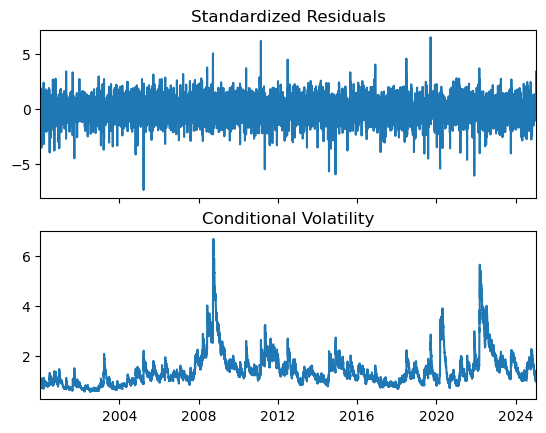

In [183]:
model_fit.plot()
plt.show()

d:\OneDrive\Documents\Personal Project Portfolio\Financial_Analysis Web App_ Plotly Dash\venv\Lib\site-packages\arch\compat\numba.py:35: PerformanceWarning:


numba is not available, and this function is being executed without JIT
compilation. Either install numba or reinstalling after installing Cython
is strongly recommended.



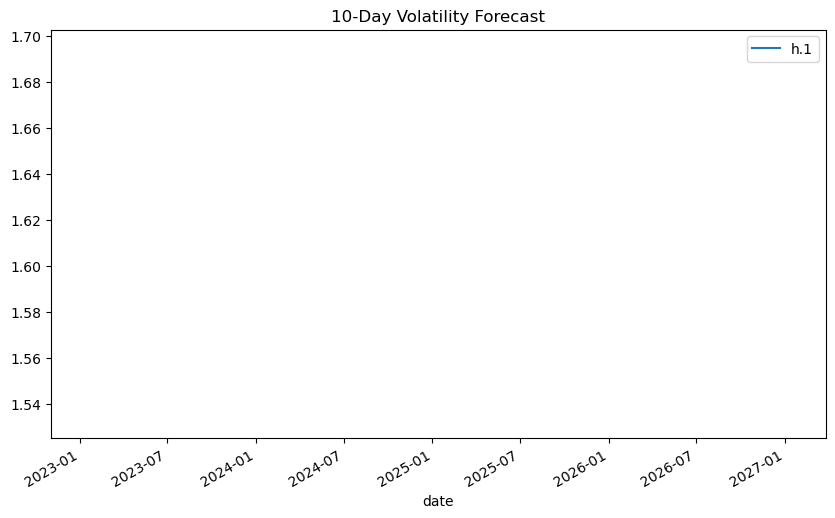

In [187]:
forecast = model_fit.forecast(horizon=1)
forecast.variance[-1:].plot(figsize=(10, 6))
plt.title("10-Day Volatility Forecast")
plt.show()